In [7]:
%matplotlib inline
from elasticsearch import Elasticsearch, helpers

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set(font="WenQuanYi Micro Hei", font_scale=1.5)
plt.style.use('ggplot')

import psycopg2

def connect():
    return psycopg2.connect(
        database='evcard',
        user='derekhe',
        password='',
        host='localhost',
        port='5432')


conn = connect()

In [8]:
all_plates = [
    "京", "津", "沪", "冀", "豫", "云", "辽", "黑", "湘", "皖", "鲁", "新", "苏", "浙", "赣",
    "鄂", "桂", "甘", "晋", "蒙", "陕", "吉", "闽", "贵", "粤", "川", "青", "藏", "琼", "宁",
    "渝"
]

In [9]:
#车数量
df = pd.read_sql("SELECT COUNT(DISTINCT(plate_num)) from sharecar_20171128",
                 conn)
df['count']

0    12855
Name: count, dtype: int64

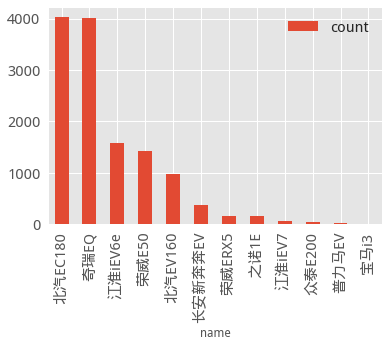

In [10]:
#车类型
df = pd.read_sql("select t.name, count(plate_num) as count from (select plate_num, name from sharecar_20171128 group by plate_num, name) as t group by name order by count desc", conn)
df.plot.bar(x='name')
df.to_json("./analysis/car_names.json", force_ascii=False, orient='records')

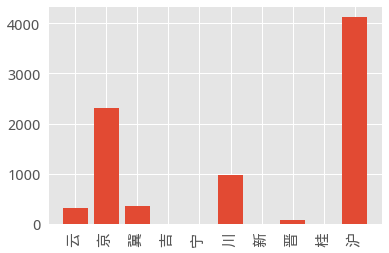

In [11]:
#各省车辆分布
def search(prefix):
    df = pd.read_sql(
        "SELECT COUNT(DISTINCT(plate_num)) from sharecar_20171128 where plate_num like '%s%%'"
        % prefix, conn)
    return df['count'][0]


x = []
y = []
for city in all_plates:
    x.append(city)
    y.append(search(city))

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

df_car = pd.DataFrame.from_records(list(zip(x,y)), columns=['province','count'])
df_car = df_car[df_car['count']!=0]
df_car.to_json("./analysis/car_distrubution.json", force_ascii=False, orient='records')

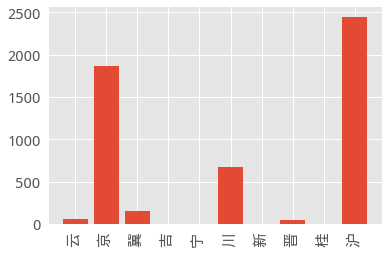

In [12]:
#各省停车场分布
def search(prefix):
    df = pd.read_sql(
        "SELECT COUNT(DISTINCT(parking_name)) from sharecar_20171128 where plate_num like '%s%%'"
        % prefix, conn)
    return df['count'][0]


x = []
y = []
for city in all_plates:
    x.append(city)
    y.append(search(city))

plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

df_park = pd.DataFrame.from_records(list(zip(x,y)), columns=['province','count'])
df_park = df_park[df_park['count']!=0]
df_park.to_json("./analysis/park_distrubution.json", force_ascii=False, orient='records')

In [13]:
df_average_cars_per_park = (df_car.set_index("province") / df_park.set_index("province"))
df_average_cars_per_park['province'] = df_average_cars_per_park.index
df_average_cars_per_park.to_json("./analysis/average_cars_per_park.json", force_ascii=False, orient='records')
df_average_cars_per_park

,count,province
province,,
沪,1.686939,沪
豫,3.490566,豫
云,5.186441,云
湘,4.058824,湘
皖,2.191860,皖
鲁,2.254777,鲁
苏,1.233280,苏
浙,1.068046,浙
赣,1.897059,赣


In [35]:
import math

#停车场位置
df = pd.read_sql(
        "SELECT position[0] as lat, position[1] as lon, parking_name from sharecar_20171128", conn)
r = 1000

df = df.drop_duplicates(subset=['parking_name'])

df.to_json("./analysis/park_locations.json", force_ascii=False, orient='records')
df

,lat,lon,parking_name
0,119.122218,28.076298,龙泉老人民医院停车场
1,121.150106,31.372228,外冈景苑四期
3,119.126620,28.075513,龙泉市荷花塘邮政储蓄
4,121.189841,31.119878,摩特威尔公司
5,121.425291,30.993491,西渡幼儿园
10,106.283028,29.591233,虎溪花园B区
12,119.695028,28.482341,丽新乡畎岸村
13,106.576061,29.535143,江南丽景
14,121.717686,31.524685,向化镇社区卫生中心
15,119.912769,28.468831,接官亭小区


In [15]:
all_tables = ["sharecar_20171011", "sharecar_20171012",
    "sharecar_20171013", "sharecar_20171014", "sharecar_20171015",
    "sharecar_20171016", "sharecar_20171017", "sharecar_20171018",
    "sharecar_20171019", "sharecar_20171020", "sharecar_20171021",
    "sharecar_20171022", "sharecar_20171024", "sharecar_20171025",
    "sharecar_20171026", "sharecar_20171027", "sharecar_20171028",
    "sharecar_20171029", "sharecar_20171030", "sharecar_20171031",
    "sharecar_20171101", "sharecar_20171102", "sharecar_20171103",
    "sharecar_20171104", "sharecar_20171105", "sharecar_20171106",
    "sharecar_20171107", "sharecar_20171108", "sharecar_20171109",
    "sharecar_20171110", "sharecar_20171111", "sharecar_20171112",
    "sharecar_20171113", "sharecar_20171114", "sharecar_20171115",
    "sharecar_20171116", "sharecar_20171117", "sharecar_20171118",
    "sharecar_20171119", "sharecar_20171120", "sharecar_20171121",
    "sharecar_20171122", "sharecar_20171123", "sharecar_20171124",
    "sharecar_20171125", "sharecar_20171126", "sharecar_20171127",
    "sharecar_20171128", "sharecar_20171129", "sharecar_20171130"]

In [16]:
#停车场数量增长
parks = []
dates = []
for table in all_tables:
    if table[-1] == '2':        
        print(table)
        df = pd.read_sql(
                "select count(distinct(parking_name)) from " + table, conn)
        parks.append(df['count'].values[0])
        dates.append(table[9:])
df = pd.DataFrame(parks, columns = ['parking_count'])
df['date'] = dates
df.to_json("./analysis/parking_increase.json", force_ascii=False, orient='records')
df

sharecar_20171012
sharecar_20171022
sharecar_20171102
sharecar_20171112
sharecar_20171122


,parking_count,date
0,4626,20171012
1,5050,20171022
2,5414,20171102
3,5770,20171112
4,6007,20171122


In [17]:
#车数量增长
parks = []
dates = []
for table in all_tables:
    if table[-1] == '2':        
        print(table)
        df = pd.read_sql(
                "select count(distinct(plate_num)) from " + table, conn)
        parks.append(df['count'].values[0])
        dates.append(table[9:])
df = pd.DataFrame(parks, columns = ['car_count'])
df['date'] = dates
df.to_json("./analysis/car_increase.json", force_ascii=False, orient='records')
df

sharecar_20171012
sharecar_20171022
sharecar_20171102
sharecar_20171112
sharecar_20171122


,car_count,date
0,9373,20171012
1,9652,20171022
2,10226,20171102
3,10994,20171112
4,12122,20171122


In [18]:
#停车场
df = pd.read_sql("select distinct(parking_name) from sharecar_20171130;", conn)
len(df)

5540

In [19]:
#车数量
df = pd.read_sql("select distinct(plate_num) from sharecar_20171130;", conn)
len(df)

12152

In [20]:
import pandas as pd
import concurrent.futures
import os


def find_parkings(plateNum):
    try:
        filename = "./out/" + plateNum + ".json"
        if os.path.exists(filename):
            return

        with connect() as conn:
            df = None
            sqls = []
            sql = ""
            for t in all_tables:
                sqls.append("""
                select time, parking_name, position, battery from %s where plate_num = '%s'
                """ % (t, plateNum))
            sql = """set max_parallel_workers_per_gather = 2;set enable_seqscan=false;"""
            sql += "UNION ALL".join(sqls)

            df = pd.read_sql(
                sql, conn,
                index_col='time').sort_index().tz_convert("Asia/Shanghai")
            df1 = df.drop_duplicates(keep='first', subset='parking_name')
            df2 = df.drop_duplicates(keep='last', subset='parking_name')
            rst = df1.combine_first(df2)
            rst.to_json(filename, force_ascii=False, date_format='iso', orient='index')
            print(plateNum)
    except Exception as ex:
        print(ex)


executor = concurrent.futures.ProcessPoolExecutor(max_workers=16)
for p in df['plate_num'].values:
    executor.submit(find_parkings, p)

executor.shutdown()

DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique for orient='index'.
DataFrame index must be unique 

In [21]:
import glob
import os.path

parkings = {}
for file in glob.glob("./out/*.json"):
    key = os.path.basename(file).replace(".json", "")
    df = pd.read_json(file, orient='index')
    if len(df) == 0:
        parkings[key] = 0
        continue
    parkings[key] = len(
        df['parking_name'].drop_duplicates())
parkings

{'苏AD06175': 70,
 '浙H6463S': 61,
 '沪FY0557': 149,
 '川A25WL9': 61,
 '沪GY8896': 178,
 '皖JEV051': 72,
 '赣A253W2': 29,
 '川AU1A57': 89,
 '川AB72C9': 102,
 '苏AD02712': 22,
 '闽GLM909': 24,
 '沪GY2186': 62,
 '沪GY3660': 96,
 '沪FY7935': 130,
 '晋H0929X': 18,
 '沪HY0235': 167,
 '苏AD06082': 42,
 '琼A0777X': 6,
 '沪AD61269': 21,
 '浙FQ107X': 92,
 '鲁B3R15U': 36,
 '沪GY8416': 170,
 '川A29YM6': 93,
 '沪AD62503': 159,
 '沪AD68092': 168,
 '沪AD07138': 157,
 '陕A9121Z': 4,
 '陕A9282Z': 5,
 '沪GY6362': 91,
 '渝D295H1': 49,
 '沪HY0501': 159,
 '沪HY3236': 160,
 '浙GB2P78': 154,
 '沪AD09210': 196,
 '苏AD01825': 30,
 '苏LVJ987': 58,
 '沪FY6185': 144,
 '鲁B79ZH3': 14,
 '云A032WC': 1,
 '沪AD09537': 168,
 '沪HY2013': 191,
 '沪AD00702': 189,
 '沪HY0416': 179,
 '鲁B93SL0': 9,
 '浙FT117F': 64,
 '川A87Q1F': 52,
 '闽GKV686': 19,
 '沪AD03958': 135,
 '沪GY2868': 166,
 '苏AD03902': 14,
 '浙KAD267': 64,
 '浙H8940R': 54,
 '皖AEV487': 40,
 '沪HY0317': 152,
 '川A50UP1': 95,
 '皖JS0607': 32,
 '浙FR595B': 153,
 '沪HY1919': 86,
 '沪GY8100': 139,
 '陕A9163Z': 1,
 '云A417KB'

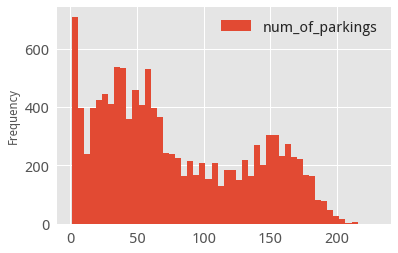

In [22]:
import numpy as np
df = pd.DataFrame.from_dict(parkings, orient='index')
df.columns = ['num_of_parkings']
df.plot.hist(bins=50)

pd.Series(np.histogram(df, bins=50)).to_json("./analysis/num_of_parkings.json", force_ascii=False, orient='records')

In [23]:
df.sort_values(by='num_of_parkings', inplace=True, ascending=False)
plates = df.index.values
plates

array(['沪HY1389', '沪FY0391', '沪HY1988', ..., 'HW196956', '云A239JJ',
       '皖AQT395'], dtype=object)

In [24]:
def export_detail(plate_num):
    df = pd.read_json("./out/" + plate_num + ".json", orient='index')
    if len(df) == 0:
        return df
    
    df = df.tz_localize(
        "UTC").tz_convert("Asia/Shanghai").reset_index()
    df = df[['index', 'parking_name']]
    df.columns = ['t', 'n']
    df['diff'] = (df['t'].shift(-1) - df['t']).fillna(0)
    df['parking'] = df['n'] == df['n'].shift(-1)
    df['start_t'] = df['t']
    df['end_t'] = df['t'].shift(-1)
    df['start_p'] = df['n']
    df['end_p'] = df['n'].shift(-1)
    df = df[['start_t', 'start_p', 'end_t', 'end_p', 'parking',
             'diff']][0:len(df) - 1]
  
    return df

In [26]:
for p in plates:
    filename = "./detail/" + p + ".json"
    if os.path.exists(filename):
        continue
    
    df = export_detail(p)
    df.to_json(filename,
        force_ascii=False,
        date_format='iso',
        orient='records')

In [27]:
import numpy as np

df_using = np.array([])
df_park = np.array([])
for p in plates:
    df = export_detail(p)
    if len(df) == 0:
        continue

    df_using = np.append(
        df_using,
        (df[df['parking'] == False]['diff'] / pd.Timedelta(hours=0.5)).values)
    df_park = np.append(
        df_park,
        (df[df['parking'] == True]['diff'] / pd.Timedelta(hours=0.5)).values)

len(df_using), len(df_park)

(1079128, 728919)

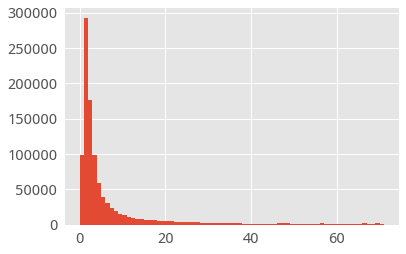

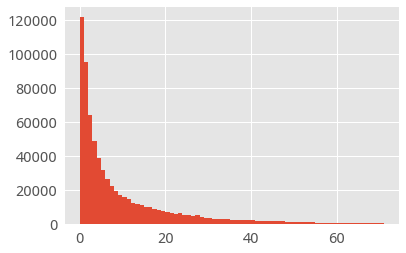

In [34]:
import matplotlib.pyplot as plt

bins=range(0,72,1)
plt.hist(df_using, bins=bins)
plt.show()

plt.hist(df_park, bins=bins)
plt.show()

In [30]:
pd.Series(np.histogram(df_using, bins=bins)).to_json("./analysis/using_hist.json", force_ascii=False, orient='records')
pd.Series(np.histogram(df_park, bins=bins)).to_json("./analysis/parking_hist.json", force_ascii=False, orient='records')

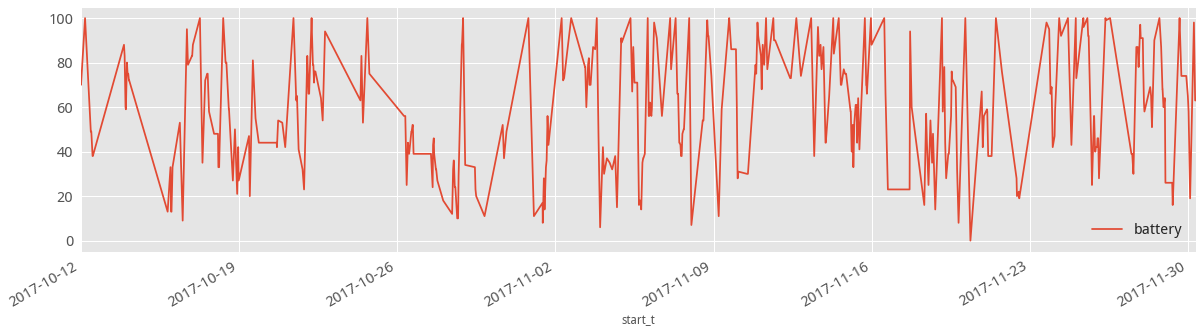

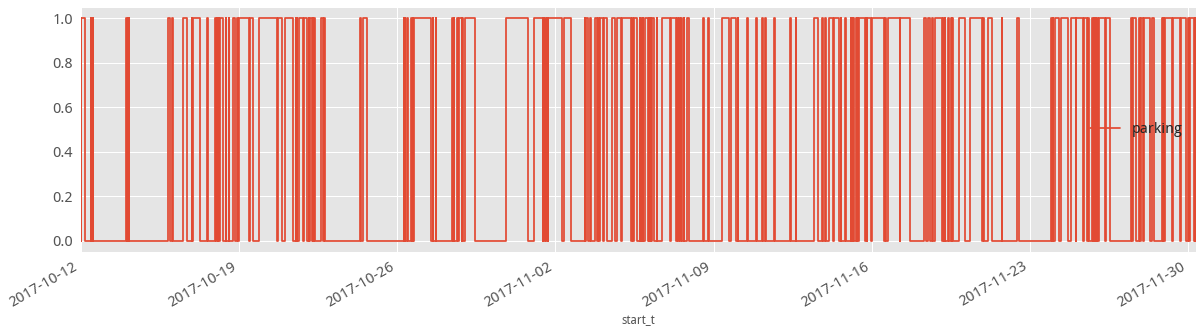

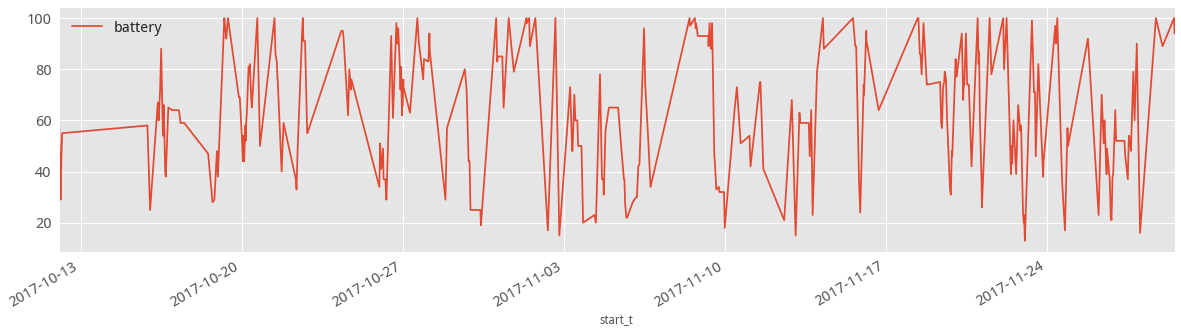

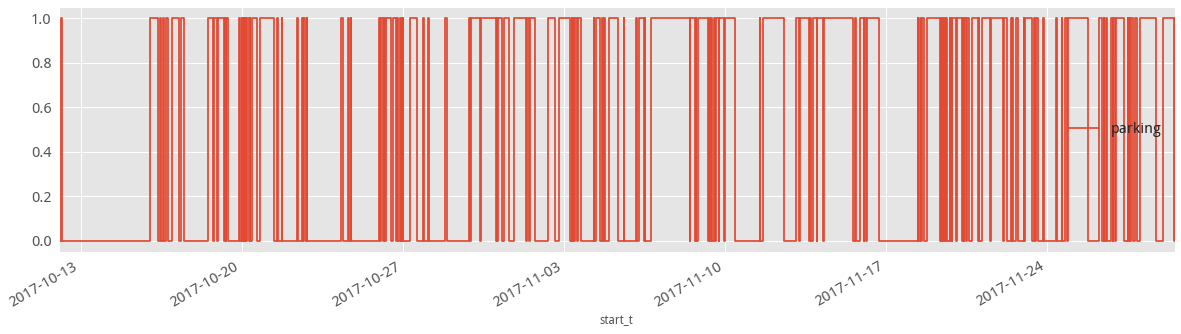

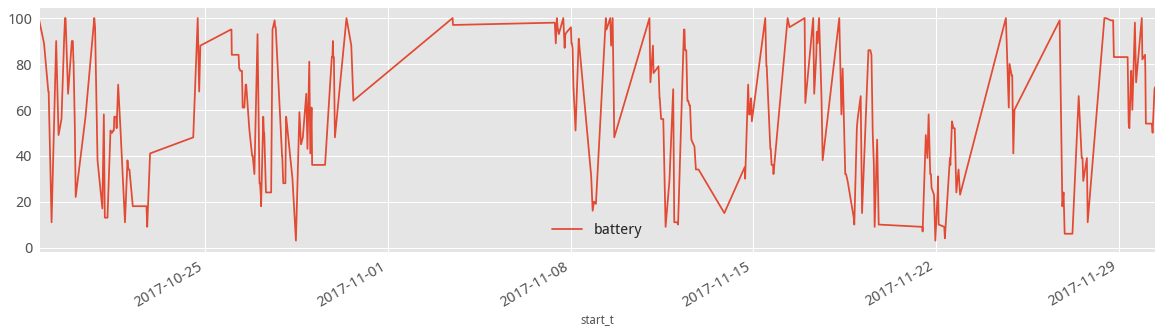

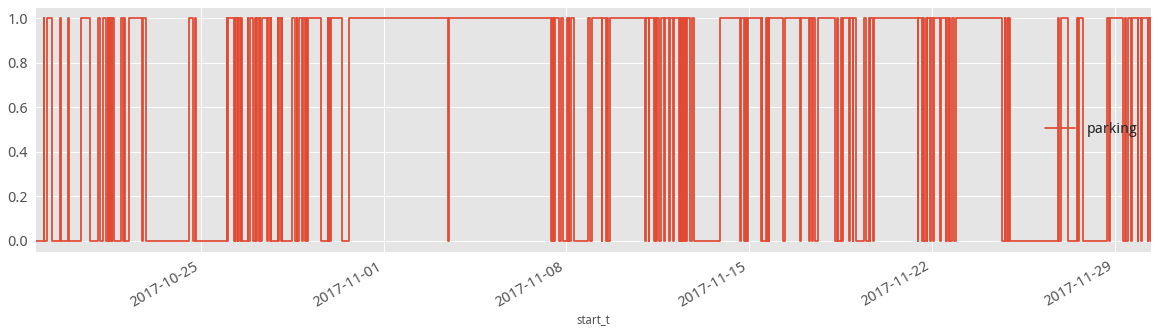

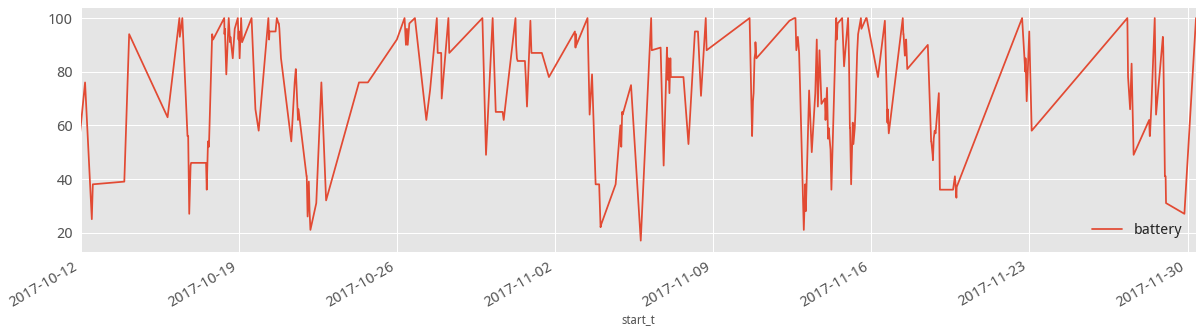

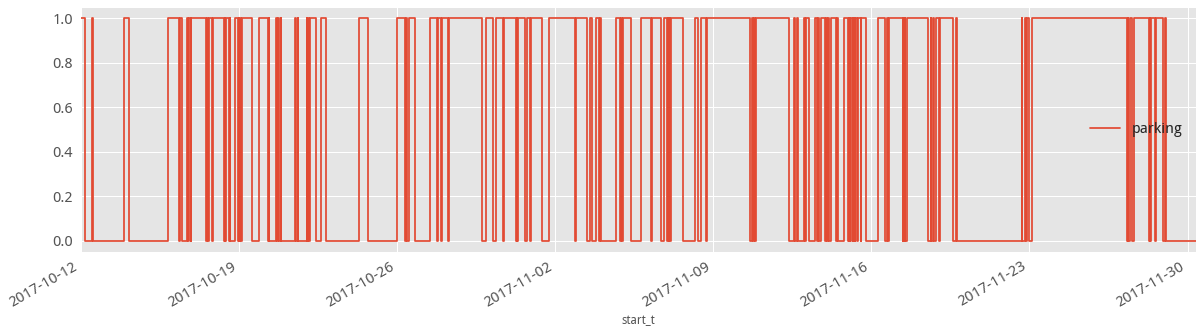

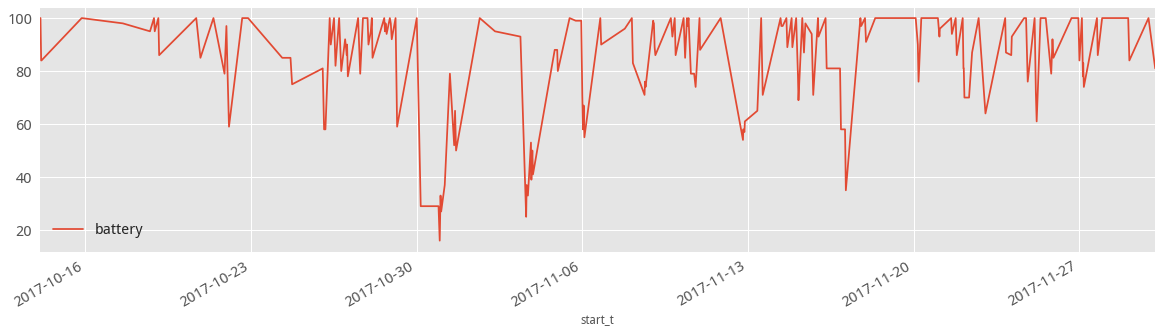

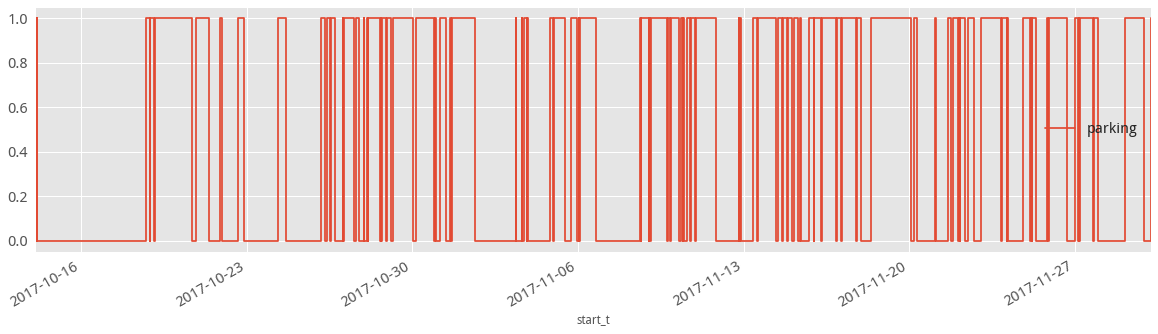

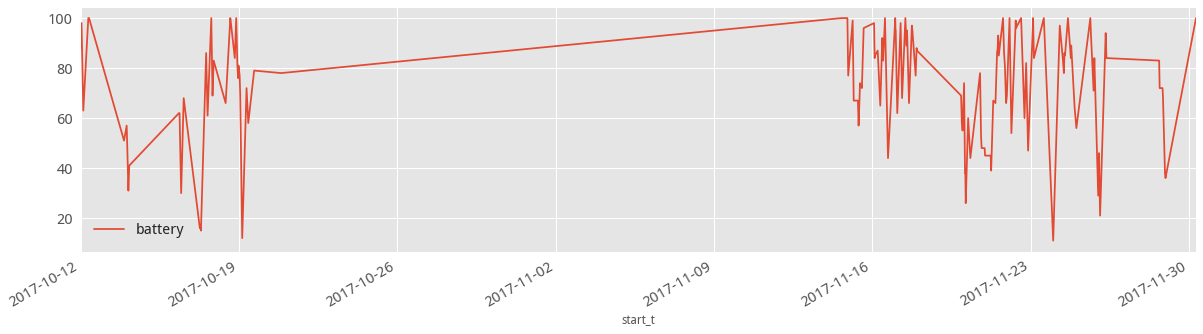

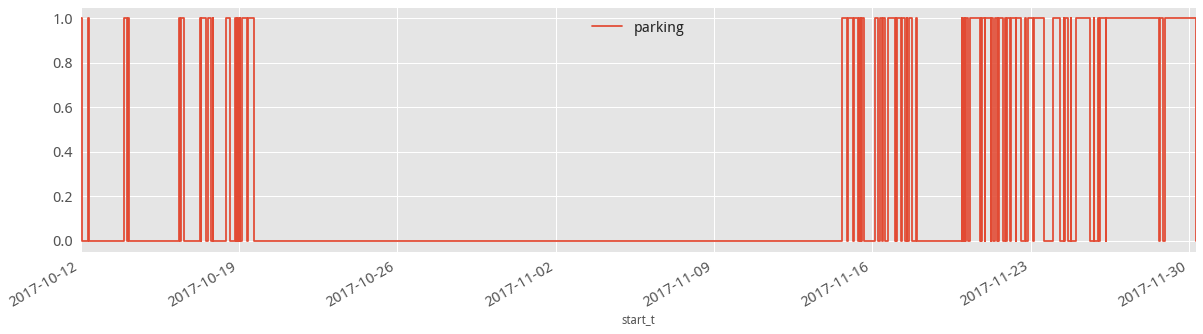

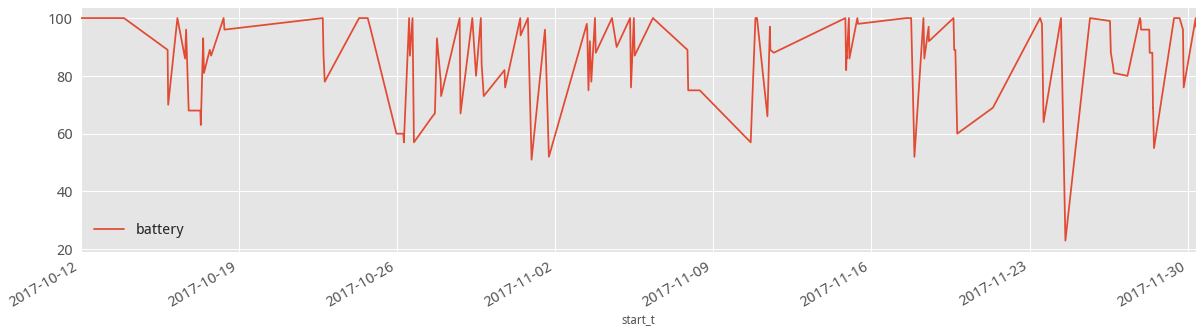

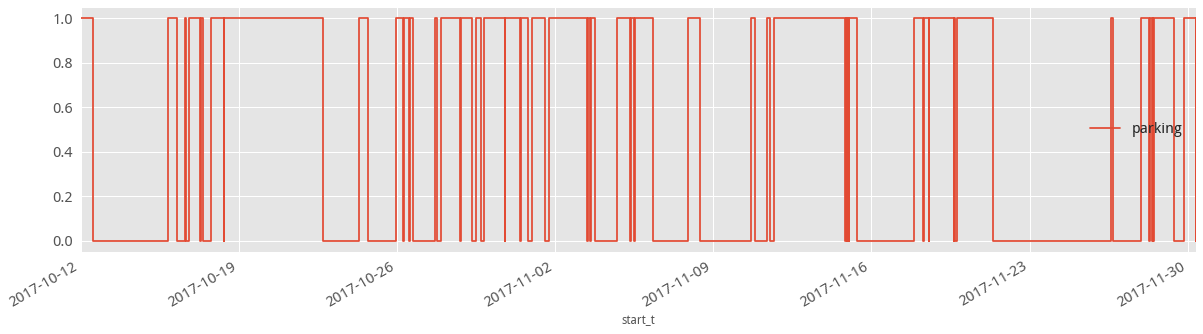

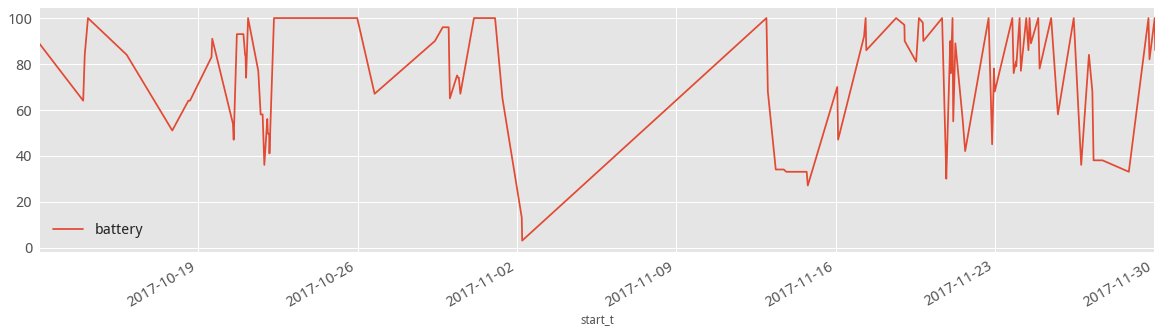

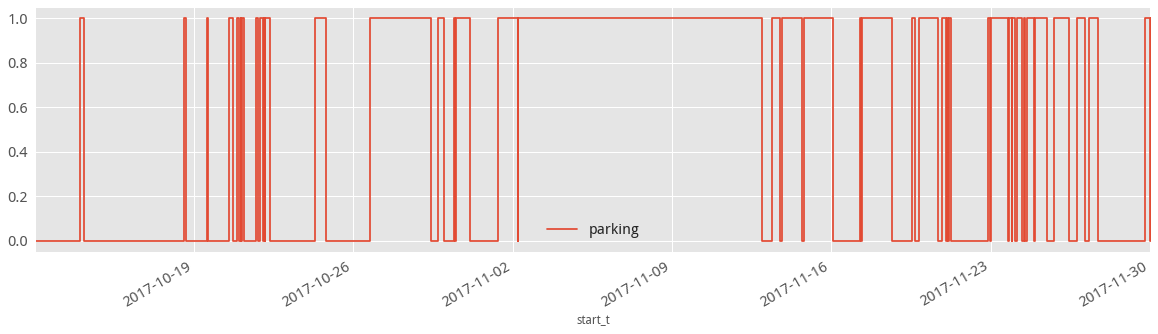

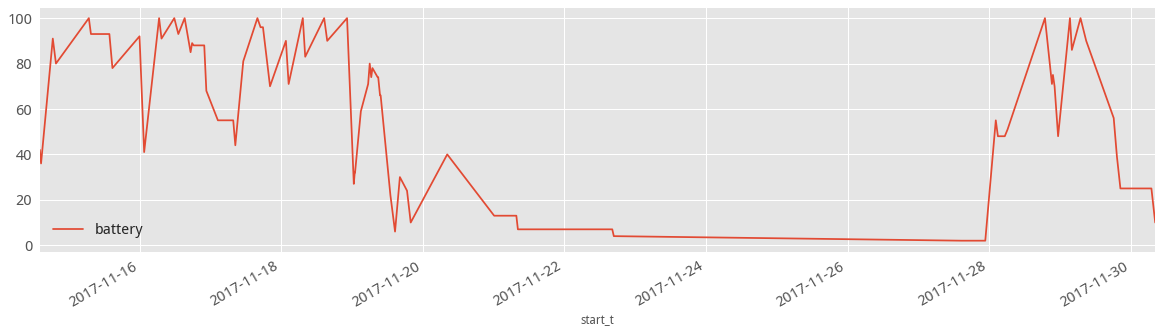

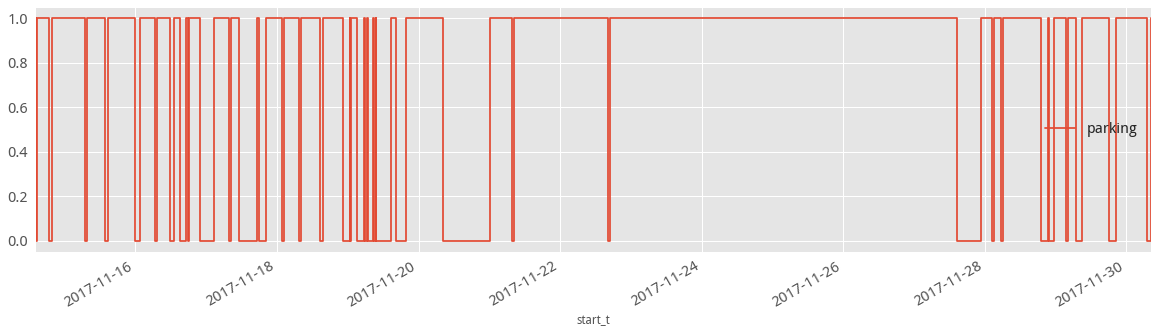

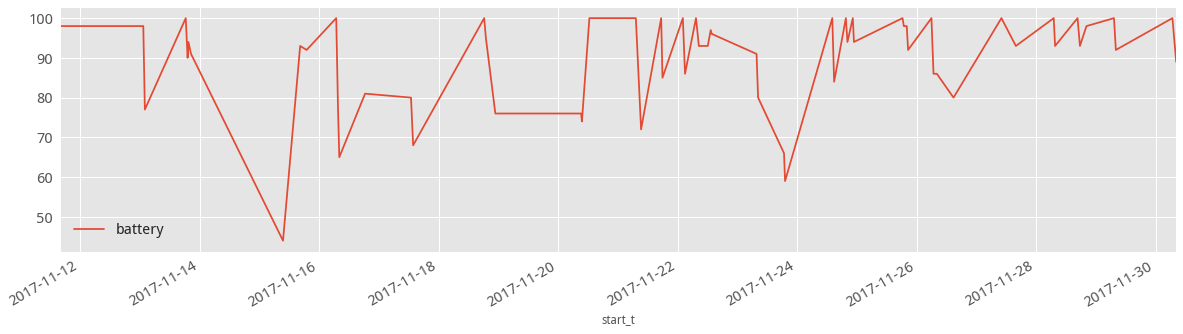

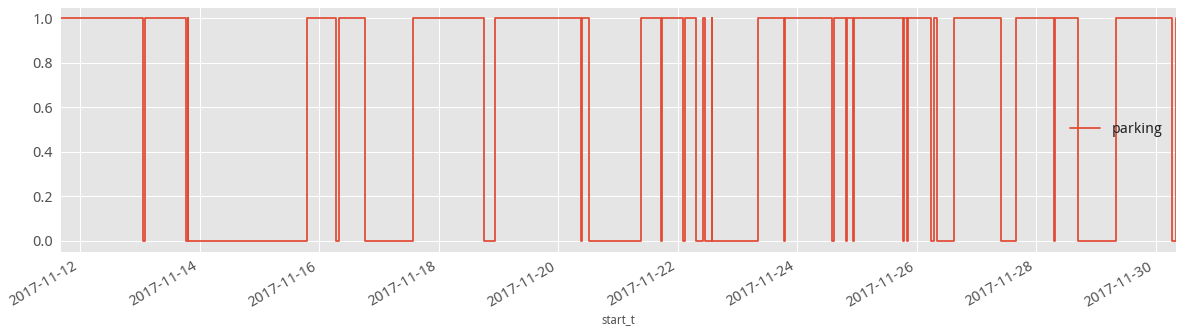

In [31]:
#%matplotlib notebook
%matplotlib inline
for i in [1,1000,2000,3000,4000,5000,6000,7000,8000,9000]:
    plate = plates[i]
    df = pd.read_json("./out/" + plate + ".json", orient='index')
    df = df.tz_localize("UTC").tz_convert("Asia/Shanghai").reset_index()
    df = df[['index', 'parking_name', 'battery','position']]
    df.columns = ['t', 'n', 'battery', 'position']
    df['diff'] = (df['t'].shift(-1) - df['t']).fillna(0)
    df['parking'] = df['n'] == df['n'].shift(-1)
    df['start_t'] = df['t']
    df['end_t'] = df['t'].shift(-1)
    df['start_p'] = df['n']
    df['end_p'] = df['n'].shift(-1)
    df = df[['start_t', 'start_p', 'end_t', 'end_p', 'parking', 'diff',
             'battery','position']][0:len(df) - 1]

    df.plot(x='start_t', y='battery', figsize=[20, 5])
    df.plot(x='start_t', y='parking', figsize=[20, 5], drawstyle="steps-post")
    df.to_json("./analysis/battery_parking_" + plate + ".json", force_ascii=False, orient='records')